### Get NBA statistics

In [1]:
import pandas as pd
from nba_api.stats.endpoints import leagueleaders


first_year = 2003
last_year = 2023
leaders_df = []

for year in range(last_year-1, first_year-1, -1):
    season = "{}-{:02}".format(year, (year+1) % 100)
    leaders = leagueleaders.LeagueLeaders(per_mode48="Per48", scope="S", season=season, season_type_all_star="Regular Season")
    leaders_season_df = leaders.get_data_frames()[0]
    leaders_season_df["SEASON"] = season
    leaders_df.append(leaders_season_df)

leaders_df = pd.concat(leaders_df, ignore_index=True)

### Read targets data from csv

In [2]:
with open('target.csv') as csv_file:
    target_names_df = pd.read_csv(csv_file)
    target_names_df = target_names_df.iloc[:15, :(last_year-first_year)]

for season in target_names_df:
    target_names = target_names_df[season].tolist()    
    idxs = (leaders_df['SEASON'] == season) & (leaders_df['PLAYER'].isin(target_names))
    leaders_df.loc[idxs, 'TARGET'] = 1
    
leaders_df.fillna({'TARGET': 0}, inplace=True)

### Split into train and test data

In [3]:
test_seasons = ['2022-23', '2017-18', '2012-13', '2007-08']
train_df = leaders_df[~leaders_df['SEASON'].isin(test_seasons)].reset_index(drop=True)
test_df = leaders_df[leaders_df['SEASON'].isin(test_seasons)].reset_index(drop=True)

### Prepare vectors of features and targets

In [4]:
from sklearn.preprocessing import MinMaxScaler


features = ['PTS', 'REB', 'FG3_PCT']

train_data = train_df[features]
test_data = test_df[features]

scaler = MinMaxScaler()
scaler.fit_transform(test_data)

train_data_norm = scaler.transform(train_data)
test_data_norm = scaler.transform(test_data)

train_target = train_df['TARGET'].to_numpy()
test_target = test_df['TARGET'].to_numpy()

### Visualize data

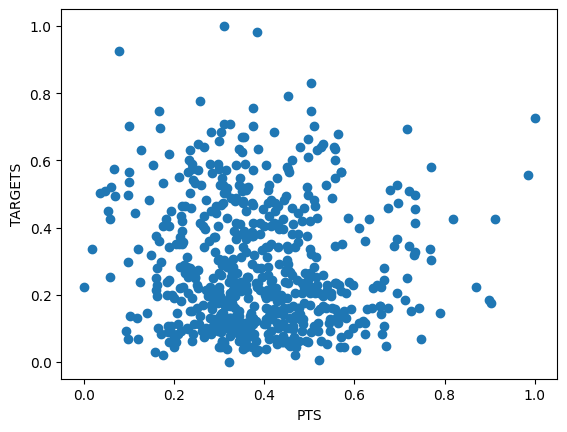

In [5]:
import matplotlib.pyplot as plt


plt.scatter(test_data_norm[:, 0], test_data_norm[:, 1])
plt.xlabel('PTS')
plt.ylabel('TARGETS')
plt.show()

### Train model

In [6]:
from sklearn.ensemble import RandomForestRegressor


clf = RandomForestRegressor()
_ = clf.fit(train_data_norm, train_target)

### Test model

In [7]:
import numpy as np


predictions = clf.predict(test_data_norm)

# TODO get top 15 players for each season from predictions  
top_15_indices = np.argpartition(predictions, -60)[-60:]
predictions_binary = np.zeros_like(predictions)
predictions_binary[top_15_indices] = 1

print(test_df[['PLAYER', 'SEASON']][predictions_binary == 1])


                      PLAYER   SEASON
0      Giannis Antetokounmpo  2022-23
1                Joel Embiid  2022-23
2                Luka Doncic  2022-23
3             Damian Lillard  2022-23
4    Shai Gilgeous-Alexander  2022-23
5               Jayson Tatum  2022-23
6           Donovan Mitchell  2022-23
7                 Trae Young  2022-23
9            Lauri Markkanen  2022-23
10              Jaylen Brown  2022-23
11              Nikola Jokic  2022-23
12              Kyrie Irving  2022-23
13        Kristaps Porzingis  2022-23
14             Julius Randle  2022-23
17              Jimmy Butler  2022-23
19              Jordan Poole  2022-23
20             DeMar DeRozan  2022-23
21            Keldon Johnson  2022-23
23             Pascal Siakam  2022-23
28              Tyrese Maxey  2022-23
76               Rudy Gobert  2022-23
105             James Harden  2017-18
106            Anthony Davis  2017-18
107             Kevin Durant  2017-18
108             LeBron James  2017-18
110    Giann